## Setup

In [ ]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize

import Bargaining as brg
import bargaining_algorithm as ba
from figures import *
from checks import *

import numpy as np
import numba as nb
import scipy.optimize as optimize
import copy

from EconModel import EconModelClass
from consav.grids import nonlinspace
from consav import linear_interp, linear_interp_1d
from consav import quadrature

#plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})

# c++ settings
do_cpp = False
do_compile = True
threads = 16

Compile C++ files

In [ ]:
# compile c++ files
if do_cpp & do_compile:
    model = brg.HouseholdModelClass(par={'do_cpp':do_cpp,'num_Ctot':100})
    model.link_to_cpp(force_compile=do_compile)

### Model settings

In [ ]:
# settings for models to solve
T = 10
do_load = True
do_save = False

specs = {
       'py baseline':    
              {'latexname':'', 
              'load': do_load,
              'save': do_save,
              'par':{'T':T,
                     'do_cpp':False,
                     'threads':threads,
                     
                     'div_A_share':0.3,
                     'sigma_love':0.0,
                     }
              },
    
       'cpp intraperiod_consumption':    
              {'latexname':'', 
              'load': do_load,
              'save': do_save,
              'par':{'T':T,
                     'do_cpp':False,
                     'threads':threads,
                     
                     'div_A_share':0.3,
                     'sigma_love':0.0,
                     'cpp_intraperiod_consumption': True,
                     }
              },
              
       'cpp value_of_choice_couple':    
              {'latexname':'', 
              'load': do_load,
              'save': do_save,
              'par':{'T':T,
                     'do_cpp':False,
                     'threads':threads,
                     
                     'div_A_share':0.3,
                     'sigma_love':0.0,
                     'cpp_intraperiod_consumption': True,
                     'cpp_value_of_choice_couple':True,
                     }
              },
              
       'cpp solve_remain_couple':    
              {'latexname':'', 
              'load': do_load,
              'save': do_save,
              'par':{'T':T,
                     'do_cpp':False,
                     'threads':threads,
                     
                     'div_A_share':0.3,
                     'sigma_love':0.0,
                     'cpp_intraperiod_consumption': True,
                     'cpp_value_of_choice_couple':True,
                     'cpp_solve_remain_couple': True,
                     }
              },
              
       'cpp':    
              {'latexname':'', 
              'load': do_load,
              'save': do_save,
              'par':{'T':T,
                     'do_cpp':True,
                     'threads':threads,
                     
                     'div_A_share':0.3,
                     'sigma_love':0.0,
                     }
              },
}

In [ ]:
def printer(specs):
    # find the longest name in specs
    max_length = 0
    for key in specs.keys():
        if len(key)>max_length:
            max_length = len(key)
            
    # get all keys in par dictionaries
    all_keys = set()
    for spec in specs.values():
        all_keys |= set(spec['par'].keys())
            
    # print header with model names
    print(f"{' '*max_length}|",end='')
    for name in specs.keys():
        print(f"{name.center(max_length)}|",end='')
    print('')
    print('-'*(max_length+1)*(len(specs.keys())+1))
        
    for p in all_keys:
        print(f"{p.ljust(max_length)}|",end='')
        for name in specs.keys():
            if p in specs[name]['par'].keys(): # use value from specs
                par_value = specs[name]['par'][p]
            else: # use default value
                model = model = brg.HouseholdModelClass()
                par_value = getattr(model.par,p)
            
            print(f"{str(par_value).center(max_length)}|",end='')
        print('')

In [ ]:
printer(specs)

Setup model1

In [ ]:
# solve different models
models = {}
for name,spec in specs.items():
        #unpack
        par = spec['par']
        do_load = spec['load']
        do_save = spec['save']
        
        if do_load:
            print(f'loading {name}...')
        else:
            print(f'solving {name}...')
        
        
        # setup model
        models[name] = brg.HouseholdModelClass(name=name, par=spec['par'], load=do_load)
        #models[name].link_to_cpp(force_compile=False)
        models[name].spec = spec
        
        # solve
        if not do_load:
            models[name].solve()
        
        # save model
        if do_save:
            models[name].save()
            
        # delink
        #models[name].cpp.delink()

## Plots

User settings

In [ ]:
# Choose models
model_names  = list(models.keys())

# Get model values
model_values = [models[name] for name in model_names]

# Choose index
t  = 0
iP = 0
iL = 0
iA = 0
idx = (t,iP,iL,iA)

Bargaining

In [ ]:
model_plot(model_values,plot_surplus,t,iP,iL,iA, subtitles=model_names)

## Focus on 2 models

In [59]:
model1 = models['py baseline']
model2 = models['cpp']

Absolute differences

In [60]:
sol_max_abs_diff = difference_in_namespace(model1.sol, model2.sol, output='max_abs_value', relative=False)
print_namespace(sol_max_abs_diff)

Vw_single: 1.3104285656595493e-08
Vm_single: 3.2822291551326543e-08
Cw_priv_single: 0.00011539274131022736
Cm_priv_single: 0.0004908678610571204
Cw_pub_single: 0.00011539274131022736
Cm_pub_single: 0.0004908678610571204
Cw_tot_single: 0.00023078548262045473
Cm_tot_single: 0.0009817357221142409
Vw_trans_single: 1.3104285656595493e-08
Vm_trans_single: 3.2822291551326543e-08
Cw_priv_trans_single: 0.00011539274131022736
Cm_priv_trans_single: 0.0004908678610571204
Cw_pub_trans_single: 0.00011539274131022736
Cm_pub_trans_single: 0.0004908678610571204
Cw_tot_trans_single: 0.00023078548262045473
Cm_tot_trans_single: 0.0009817357221142409
Vw_couple: 0.0004775670328953652
Vm_couple: 0.0005336584289716839
Cw_priv_couple: 0.038624546518186476
Cm_priv_couple: 0.045418790509267115
C_pub_couple: 0.05752136988159151
C_tot_couple: 0.10632288441848292
Vw_remain_couple: 0.003010957207844278
Vm_remain_couple: 0.001740500152090263
Cw_priv_remain_couple: 0.056712133572053514
Cm_priv_remain_couple: 0.0480983

Relative differences

In [61]:
sol_max_rel_diff = difference_in_namespace(model1.sol, model2.sol, output='max_abs_value', relative=True)
print_namespace(sol_max_rel_diff)

Vw_single: 2.955090762587939e-09
Vm_single: 1.290715386889833e-08
Cw_priv_single: 0.00018630079091498327
Cm_priv_single: 0.0007118888743326541
Cw_pub_single: 0.00018630079091498327
Cm_pub_single: 0.0007118888743326541
Cw_tot_single: 0.00018630079091498327
Cm_tot_single: 0.0007118888743326541
Vw_trans_single: 2.955090762587939e-09
Vm_trans_single: 1.290715386889833e-08
Cw_priv_trans_single: 0.00018630079091498327
Cm_priv_trans_single: 0.0007118888743326541
Cw_pub_trans_single: 0.00018630079091498327
Cm_pub_trans_single: 0.0007118888743326541
Cw_tot_trans_single: 0.00018630079091498327
Cm_tot_trans_single: 0.0007118888743326541
Vw_couple: 7.067026669730796
Vm_couple: 7.081364374084266
Cw_priv_couple: 0.24136474955582132
Cm_priv_couple: 1.0235369521892341
C_pub_couple: 0.033236215687277436
C_tot_couple: 0.033347641226759754
Vw_remain_couple: 7.067026669730796
Vm_remain_couple: 7.081364374084266
Cw_priv_remain_couple: 0.03650539804813071
Cm_priv_remain_couple: 0.036500980189747255
C_pub_re

/Users/ahj/Library/CloudStorage/OneDrive-UniversityofCopenhagen/Documents/projects/household_guide/HouseholdBargainingGuide/checks.py:51: RuntimeWarning: divide by zero encountered in divide
  diff = np.where(var1 == 0, np.nan, (var2 - var1)/var1)
/Users/ahj/Library/CloudStorage/OneDrive-UniversityofCopenhagen/Documents/projects/household_guide/HouseholdBargainingGuide/checks.py:51: RuntimeWarning: invalid value encountered in divide
  diff = np.where(var1 == 0, np.nan, (var2 - var1)/var1)
/Users/ahj/Library/CloudStorage/OneDrive-UniversityofCopenhagen/Documents/projects/household_guide/HouseholdBargainingGuide/checks.py:71: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(np.abs(variable))


In [ ]:
sol_max_rel_diff_index = difference_in_namespace(model1.sol, model2.sol, output='max_abs_index', relative=False)
print_namespace(sol_max_rel_diff_index)

## Plot the differences

Specify the variable that index of maximum absolute difference should be based on

In [58]:
variable = 'Vw_couple'

Find index with largest difference

In [ ]:
sol_max_abs_diff_idx = difference_in_namespace(model1.sol, model2.sol, output='max_abs_index', relative=False)

In [ ]:
idx = getattr(sol_max_abs_diff_idx,variable)

(t,iP,iL,iA) = idx
print(f't = {t}, iP = {iP}, iL = {iL}, iA = {iA}')

### Bargaining power

In [ ]:
model_plot([model1,model2],plot_surplus,t,iP,iL,iA, subtitles=[model1.name,model2.name])

### Values

Plot female values

In [ ]:
model_plot([model1,model2], plot_var_over_assets, ['Vw_couple','Vw_remain_couple','Vw_single'], idx, grid_points=False, subtitles=[model1.name, model2.name ])

In [ ]:
model_plot([model1,model2], plot_var_over_time, ['Vw_couple','Vw_remain_couple','Vw_single'], idx, subtitles=[model1.name, model2.name ])

Plot male values

In [ ]:
model_plot([model1,model2], plot_var_over_assets, ['Vm_couple','Vm_remain_couple','Vm_single'], idx, grid_points=False, subtitles=[model1.name, model2.name ])

### Consumption

Plot female consumption

In [ ]:
model_plot([model1,model2], plot_var_over_assets, ['Cw_priv_couple','Cw_priv_remain_couple','Cw_priv_single', 'Cw_priv_trans_single'], idx, grid_points=False, subtitles=[model1.name, model2.name ])

Plot male consumption

In [ ]:
model_plot([model1,model2], plot_var_over_assets, ['Cm_priv_couple','Cm_priv_remain_couple','Cm_priv_single', 'Cm_priv_trans_single'], idx, grid_points=False, subtitles=[model1.name, model2.name ])

Plot public consumption

In [ ]:
model_plot([model1,model2], plot_var_over_assets, ['C_pub_couple','C_pub_remain_couple','Cm_pub_single', 'Cw_pub_trans_single', 'Cm_pub_trans_single'], idx, grid_points=False, subtitles=[model1.name, model2.name ])

## Plots of difference

In [ ]:
model_diff =  brg.HouseholdModelClass(name='Model differences')
model_diff.par = model1.par
model_diff.sol = difference_in_namespace(model1.sol, model2.sol)

Plot value

In [ ]:
model_plot([model_diff], plot_var_over_time, ['Vw_couple','Vw_remain_couple','Vw_single'], idx, subtitles=[model_diff.name])

Plot consumption

In [ ]:
# plot pre_Ctot_Cw_priv in a 3 dimensional plot with using meshgrids 
fig = plt.figure()
ax = plt.axes(projection='3d')
mesh1, mesh2 = np.meshgrid(model1.par.grid_power, model1.par.grid_Ctot, indexing='ij')

ax.plot_surface(mesh1,mesh2, model_diff.sol.pre_Ctot_Cw_priv, cmap='viridis', edgecolor='none')

# label axes
ax.set_xlabel('Power')
ax.set_ylabel('Ctot')


## PY to CPP decoposition

In [62]:
model_bank = {}
model_bank[1] = models['py baseline']
model_bank[2] = models['cpp intraperiod_consumption']
model_bank[3] = models['cpp value_of_choice_couple']
model_bank[4] = models['cpp solve_remain_couple']
model_bank[5] = models['cpp']

output = ''
relative = False

var = 'Vm_couple'

Find index with largest difference

In [63]:
sol_max_abs_diff_idx = difference_in_namespace(model1.sol, model2.sol, output='max_abs_index', relative=False)
idx = getattr(sol_max_abs_diff_idx,var)

(t,iP,iL,iA) = idx
print(f't = {t}, iP = {iP}, iL = {iL}, iA = {iA}')

t = 2, iP = 13, iL = 20, iA = 22


Calculate differences

In [64]:
diff = {}
model_diff = brg.HouseholdModelClass(name=f'PY to CPP decomposition')

# Calculate differences
for i in range(1,6):
    diff[i]             = difference_in_namespace(model_bank[1].sol, model_bank[i].sol, output=output, relative=relative)
    for v in model_bank[1].sol.__dict__.keys():
        setattr(model_diff.sol,f'{v} ({model_bank[i].name})',getattr(diff[i],v))

Plot decomposition 

In [65]:
# Group diffs of the same variable
plot_vars_diff = {}
for v in model_bank[1].sol.__dict__.keys():
    plot_vars_diff[v] = [f'{v} ({model_bank[i].name})' for i in range(1,6)]

In [66]:
plot_vars_diff[var]

['Vm_couple (py baseline)',
 'Vm_couple (cpp intraperiod_consumption)',
 'Vm_couple (cpp value_of_choice_couple)',
 'Vm_couple (cpp solve_remain_couple)',
 'Vm_couple (cpp)']

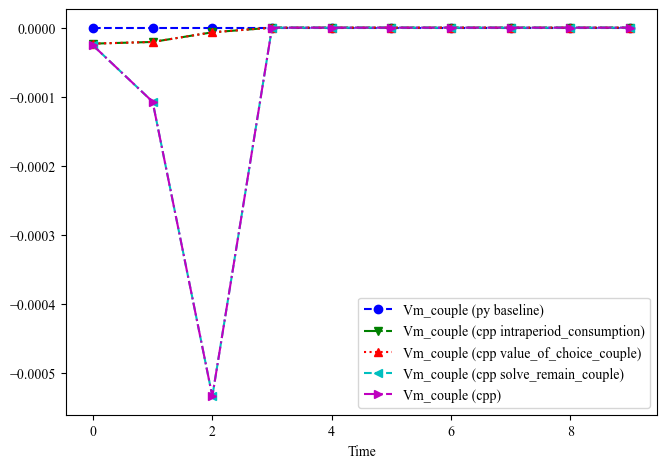

In [67]:
plot_var = var

colors = ['b', 'g', 'r', 'c', 'm']
linestyles = ['--', '-.', ':', '--', '-.']
markers = ['o', 'v', '^', '<', '>']
plt.rc('axes', prop_cycle=(plt.cycler('color', colors) + plt.cycler('linestyle', linestyles) + plt.cycler('marker', markers)))


model_plot(model_diff, plot_var_over_time, plot_vars_diff[plot_var], idx, subtitles=None)


In [ ]:
getattr(model_diff.sol,'Cw_pub_trans_single (cpp value_of_choice_couple)')

In [ ]:
# Make a random dict
d = {}
d['a'] = 1
d['b'] = 2
d['c'] = 3

list(d.values())[1]